# Early cancer detection using signature framework

On essaie ici de différentier les dynamiques malignes des dynamiques bénignes pour les biomarqueurs.

In [1]:
!pip install iisignature
!pip install signatory

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp310-cp310-linux_x86_64.whl size=3245484 sha256=cfb4eb068022152173f441ea5adabff3e10d82b805fc34215096690246f45c1b
  Stored in directory: /root/.cache/pip/wheels/c8/13/d1/42e1aa7f8a8e1189360df53c461f0e13f43e0d2170ef16d349
Successfully built iisignature
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for signatory: filename=signatory-1.2.6.1.9.0-cp310-cp310-linux_x86_64.whl size=11869422 sha256=c0f644a664358dce4f7d342a85d89233d38bb58c7bc3731027b8f6dc440345be
  Stored in directory: /root/.cache/pip/wheels/71/b4/17/46d769da4808e9f83f9790a2b805f81f43ececc2c02f5b1e62
Successfully built signatory


In [2]:
import signatory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch


In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Etude_Cancer

from pga import pga



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-82d8ed8e0fe3>", line 1, in <cell line: 1>
    get_ipython().run_line_magic('cd', '/content/drive/MyDrive/Etude_Cancer')
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2418, in run_line_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-85>", line 2, in cd
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py", line 342, in cd
    oldcwd = os.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/c

On importe les données bénignes:

In [ ]:
data = {}
for b in [0.02,0.07,0.14,0.21,0.28]:
  df = pd.read_csv("./Simul/benign_dwi_b"+str(b)+".csv",sep = ";")
  df_numpy = df.to_numpy().T[:,:,None]
  data[str(b)]= torch.tensor(pd.read_csv("./Simul/benign_dwi_b"+str(b)+".csv",sep = ";").to_numpy().T[:,:,None])

Pour les passer dans signatory, il faut absolument un torch.tensor. De plus, pour certains propriétés de la signature, on doit inclure un deuxième canal pour obtenir des trajectoires de la forme $(t,X_t)$

In [ ]:
time = torch.tensor([300*i for i in range(7)])[None,:,None]
times = time.repeat(1000,1,1)


In [ ]:
for arrays in data:
  data[arrays]=torch.cat((data[arrays][1:],times),dim = -1)


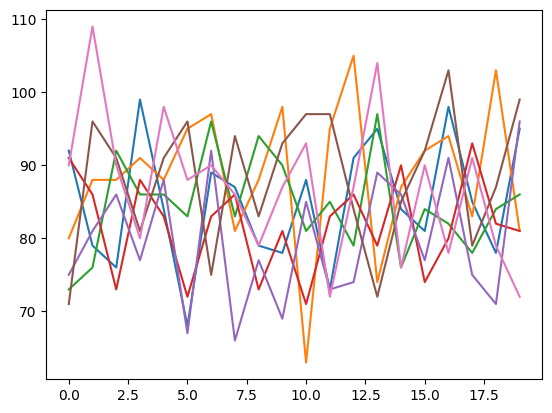

In [ ]:
data_ben = torch.cat((data['0.02'],data['0.07'],data['0.14'],data['0.21'],data['0.28']))
plt.plot(data_ben[:20,:,0])

(array([1000.,  663.,  337.,   38.,  961.,    1.,  874.,  126.,  390.,
         610.]),
 array([  55. ,  178.6,  302.2,  425.8,  549.4,  673. ,  796.6,  920.2,
        1043.8, 1167.4, 1291. ]),
 <BarContainer object of 10 artists>)

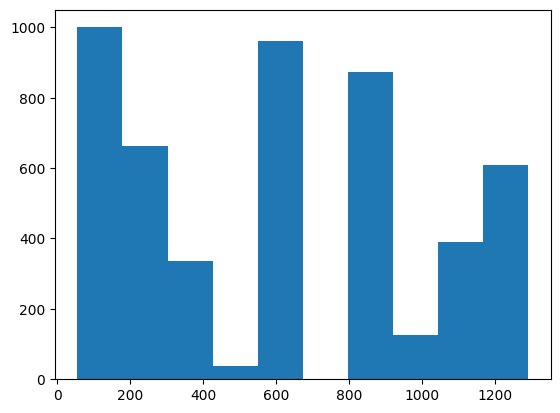

In [ ]:
plt.hist(data_ben[:,1,0])

On a simulé des données béngines avec différents paramètres, donc on en fait un gros tenseur avec tout le monde

In [ ]:
data_ben = torch.cat((data['0.02'],data['0.07'],data['0.14'],data['0.21'],data['0.28']))
data_ben[:,:,1] = data_ben[:,:,1]/1800
data_ben[:,:,0] = (data_ben[:,:,0].T-data_ben[:,:,0].mean(axis=1)).T


In [ ]:
data_ben[1,:,0]

tensor([-1535.8571, -1041.8571,  -528.8571,    19.1429,   593.1429,   982.1429,
         1512.1429], dtype=torch.float64)

C'est le point crucial:

On a un batch de 5000 trajectoires, avec 7 temps de sampling chacun, et 2 canaux (d'où une shape (5000,7,2)).

On calcule leurs signatures à l'ordre 3. Ce qui va nous donner 15 coeffs par trajectoire.

In [ ]:
depth = 3
shape = signatory.signature_channels(2,depth) # 2 = nombre de canaux
signature_ben = np.empty([1000*len(data),shape+1])
print(signature_ben.shape)
#i = 0
#for arrays in data:
#  signature[i:i+1000,:shape] = signatory.signature(data[arrays],depth = 2,basepoint = True)
#  i+=1
signature_ben[:,:shape] = signatory.signature(data_ben,depth = depth,basepoint = True)# On rajoute (ou pas) articiellement un point initial t_0=0
signature_ben[:,-1] = np.abs(signature_ben[:,3]-signature_ben[:,4]) #On crée l'aire de Levy S12-S21
signature_ben.shape

(5000, 15)


(5000, 15)

(array([5.000e+00, 2.000e+01, 1.780e+02, 4.724e+03, 5.700e+01, 9.000e+00,
        3.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([-123829.01068999,  -86003.61127308,  -48178.21185617,
         -10352.81243926,   27472.58697765,   65297.98639456,
         103123.38581147,  140948.78522838,  178774.18464529,
         216599.5840622 ,  254424.98347911]),
 <BarContainer object of 10 artists>)

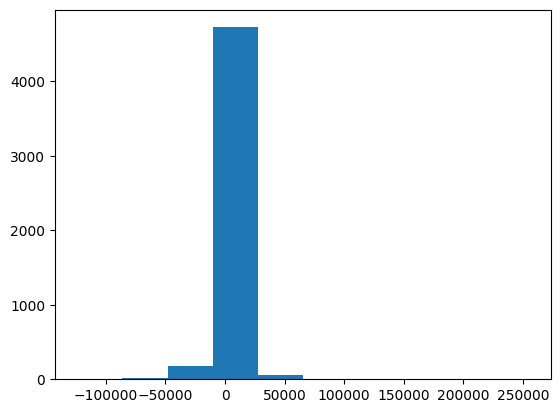

In [ ]:
i = 6
plt.hist(signature_ben[:,i])

On calcule les quantiles

In [ ]:
quant_ben = np.quantile(np.abs(signature_ben), q= 0.95, axis = 0)
print(quant_ben)

[4.85714286e+01 1.00000000e+00 1.17959184e+03 5.22678571e+00
 5.22500000e+01 5.00000000e-01 1.90981535e+04 4.65853401e+02
 1.05128155e+03 5.86805556e+00 1.66404722e+03 1.03898148e+01
 2.46136574e+01 1.66666667e-01 5.53821429e+01]


In [ ]:
import os
import re


def starts_with_benign(s):
    return s.startswith("benign")
classif = []
data_ben_mal = {}
directory = './Simul'
for filename in os.listdir(directory):
    if starts_with_benign(filename):
      i = 1
    else:
      f = os.path.join(directory, filename)
      data_ben_mal[filename]= torch.tensor(pd.read_csv(f,sep = ";").to_numpy().T[:,:,None])


In [ ]:
time = torch.tensor([300*i for i in range(7)])[None,:,None]
print(time.shape)
times = time.repeat(1000,1,1)
times.shape

torch.Size([1, 7, 1])


torch.Size([1000, 7, 1])

In [ ]:
for arrays in data_ben_mal:
  data_ben_mal[arrays]=torch.cat((data_ben_mal[arrays][1:],times),dim = -1)

In [ ]:
data_mal = torch.cat(tuple([data_ben_mal[filename] for filename in data_ben_mal.keys()]))
data_mal[:,:,1] = data_mal[:,:,1]/1800
data_mal[:,:,0] = (data_mal[:,:,0].T-data_mal[:,:,0].mean(axis=1)).T


In [ ]:
depth = 3
shape = signatory.signature_channels(2,depth)
signature_mal = np.empty([1000*len(data_ben_mal),shape+1])
print(signature_mal.shape)
#i = 0
#for arrays in data:
#  signature[i:i+1000,:shape] = signatory.signature(data[arrays],depth = 2,basepoint = True)
#  i+=1
signature_mal[:,:shape] = signatory.signature(data_mal,depth = depth,basepoint = True)
signature_mal[:,-1] = np.abs(signature_mal[:,3]-signature_mal[:,4])

(66000, 15)


## Test:
Dans la cellule suivante, on teste chaque coefficient:
Si coeff>quantile => 1, sinon 0.


In [ ]:
res_pos = []
for i in range(signature_mal.shape[-1]):
  res_pos.append(sum(np.abs(signature_mal[:,i])>quant_ben[i])/signature_mal.shape[0])
  print(sum(np.abs(signature_mal[:,i])>quant_ben[i])/signature_mal.shape[0])

NameError: name 'quant_ben' is not defined

In [ ]:
TP = []
FN = []
for i in range(signature_mal.shape[-1]):
  TP.append(sum(np.abs(signature_mal[:,i])>quant_ben[i]))
  FN.append(signature_mal.shape[0]-sum(np.abs(signature_mal[:,i])>quant_ben[i]))

print("TP:"+str(TP))
print("Fn:"+str(FN))

TP = np.array(TP)
FN = np.array(FN)

In [ ]:
TN = []
FP = []
for i in range(signature_mal.shape[-1]):
  FP.append(sum(np.abs(signature_ben[:,i])>quant_ben[i]))
  TN.append(signature_ben.shape[0]-sum(np.abs(signature_ben[:,i])>quant_ben[i]))

print("TN:"+str(TN))
print("FP:"+str(FP))

TN = np.array(TN)
FP = np.array(FP)

TN:[4750, 5000, 4750, 4750, 4751, 5000, 4750, 4750, 4750, 4750, 4750, 4750, 4750, 5000, 4750]
FP:[250, 0, 250, 250, 249, 0, 250, 250, 250, 250, 250, 250, 250, 0, 250]


In [ ]:
TN

array([250,   0, 250, 250, 250,   0, 250, 250, 250, 250, 250, 249, 250,
         0, 250])

In [ ]:
test_mult_no_corr = []
for i in range(signature_mal.shape[0]):
  test_mult_no_corr.append(sum(np.abs(signature_mal[i])>quant_ben)>0)
sum(test_mult_no_corr)/signature_mal.shape[0]



0.9996363636363637

In [ ]:
# Calcul de l'accuracy
accuracy = (TP + TN) / (TP + TN + FP + TN)

# Calcul de la précision
precision = TP / (TP + FP)

# Calcul du recall
recall = TP / (TP + FN)

# Calcul du F1 Score
f1_score = 2 * precision * recall / (precision + recall)

print(f'Accuracy: {accuracy.T}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-SCORE: {f1_score}')

df = pd.DataFrame(data = {'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-Score':f1_score})

print(df)


Accuracy: [0.93397074 0.5        0.93397074 0.93380114 0.93397161 0.5
 0.93397074 0.93372041 0.93383968 0.93389653 0.93396289 0.9337081
 0.93395765 0.5        0.93397161]
Precision: [0.99622493        nan 0.99622493 0.99621384 0.99623998        nan
 0.99622493 0.99620856 0.99621636 0.99622008 0.99622442 0.99620775
 0.99622408        nan 0.99622499]
Recall: [0.99960606 0.         0.99960606 0.99666667 0.99960606 0.
 0.99960606 0.99527273 0.99733333 0.99831818 0.9994697  0.99506061
 0.99937879 0.         0.99962121]
F1-SCORE: [0.99791263        nan 0.99791263 0.9964402  0.99792018        nan
 0.99791263 0.99574042 0.99677454 0.99726803 0.99784442 0.99563385
 0.99779894        nan 0.99792021]
    Accuracy  Precision    Recall  F1-Score
0   0.933971   0.996225  0.999606  0.997913
1   0.500000        NaN  0.000000       NaN
2   0.933971   0.996225  0.999606  0.997913
3   0.933801   0.996214  0.996667  0.996440
4   0.933972   0.996240  0.999606  0.997920
5   0.500000        NaN  0.000000    

<ipython-input-33-a3e6fb7ce390>:5: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)


In [ ]:
TP_mult = sum(test_mult_no_corr)
FN_mult = signature_mal.shape[0]-sum(test_mult_no_corr)

print("TP:"+str(TP_mult))
print("FN:"+str(FN_mult))

test_mult_no_corr_ben = []
for i in range(signature_ben.shape[0]):
  test_mult_no_corr_ben.append(sum(np.abs(signature_ben[i])>quant_ben)>0)

TN_mult = signature_ben.shape[0]-sum(test_mult_no_corr_ben)
FP_mult = sum(test_mult_no_corr_ben)
print("TN:"+str(TN_mult))
print("FP:"+str(FP_mult))


TP:65974
FN:26
TN:4263
FP:737


In [ ]:
# Calcul de l'accuracy
accuracy_multi = (TP_mult + TN_mult) / (TP_mult + TN_mult + FP_mult + TN_mult)

# Calcul de la précision
precision_multi = TP_mult / (TP_mult + FP_mult)

# Calcul du recall
recall_multi = TP_mult / (TP_mult + FN_mult)

# Calcul du F1 Score
f1_score_multi = 2 * precision_multi * recall_multi / (precision_multi + recall_multi)


print(f'Accuracy: {accuracy_multi}')
print(f'Precision: {precision_multi}')
print(f'Recall: {recall_multi}')
print(f'F1-SCORE: {f1_score_multi}')

Accuracy: 0.9335433363903398
Precision: 0.9889523466894515
Recall: 0.9996060606060606
F1-SCORE: 0.9942506649787884


# Analyse PGA

Ici on dispose de 3 fonctions qui ont leurs propres utilités:

- compute_pga permets de calculer quelles sont les 3 géodésiques principales qui portent nos données.
- projections permets de calculer les coordonnées de chaques données dans les 3 géodésiques principales.
- visualisation permets de visualiser les données dans les différentes géodésiques principales.



In [ ]:
from pga import pga
from pga import tangent_pga

from pga import recenter_group_elems
from pga import d2h
from utils import depth_inds

from scipy.optimize import fsolve

def compute_pga(path, sig_level, tangent = True, n_components = 3):
  print('Computing signatures')
  sig = signatory.Signature(depth  = sig_level)
  signatures = sig(path,basepoint = True)
  channels = path.shape[-1]

  if tangent:
      print('Computing tangent pga')
      t_principal_directions = tangent_pga(signatures.numpy(), channels, sig_level, n_components=n_components)
  else:
      print('Computing pga')
      t_principal_directions = pga(signatures.numpy(), channels, sig_level, n_components=n_components)
  return t_principal_directions, signatures


def compute_projection(t_principal_directions,path,channels,depth):
  print('Computing tangent pga projections')
  channels = path.shape[-1]
  inds = depth_inds(channels, depth)
  sig = signatory.Signature(depth  = depth)
  signatures = sig(path,basepoint = True)
  projections_t = {}
  n_components = len(t_principal_directions)
  for K in range(n_components):
      optimized_v_t = t_principal_directions[K]
      SXk = recenter_group_elems(signatures.numpy(), channels, depth, inds)
      tis_t = []
      for i in range(len(signatures.numpy())):
          d2h_t = lambda t: d2h(t, optimized_v_t, SXk[i], depth, channels)
          initial_guess_t = 0.
          optimized_ti_t = fsolve(d2h_t, initial_guess_t)[0]
          tis_t.append(optimized_ti_t)
          print(f'Data #{i} with component #{K}')
      tis_t = np.array(tis_t)
      projections_t[K] = tis_t
  var_t = [np.var(projections_t[k]) for k in range(n_components)]
  print('Variance expliquée par les 3 premières géodésiques principales'+str(var_t))

  return projections_t

def visualisation_normales(projections,colour):


  for pg in range(1,len(projections)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(len(projections[0])):
        ax.scatter(projections[0][i],projections[pg][i], color=colour[i])
    plt.title('Data vizualisation on the two first principal geodesics')
    plt.xlabel("PG1")
    plt.ylabel(f"PG{pg+1}")
    plt.show()

  fig = plt.figure()
  ax = fig.add_subplot(111,projection = '3d')

  for i in range(len(projections[0])):
      ax.scatter(projections[0][i],projections[1][i],projections[2][i] , color=colour[i])
  plt.title('Visualisation des données sur les 3 premières géodésiques')
  plt.show()

def visualisation_all(projections_norm,projections_anorm):

  for pg in range(1,len(projections_norm)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(len(projections_norm[0])):
        ax.scatter(projections_norm[0][i],projections_norm[pg][i], color=['blue'])
    for i in range(len(projections_anorm[0])):
        ax.scatter(projections_anorm[0][i],projections_anorm[pg][i], color=['red'])

    plt.title('Data vizualisation on the two first principal geodesics')
    plt.xlabel("PG1")
    plt.ylabel(f"PG{pg+1}")
    plt.legend(['Benign','Malignant'])
    plt.show()

def leadlag(X):
        '''
        lead-lag transformation of one dimensional TS [T,1] -> [2T-1, 2]

        Parameters
        ----------
        X : tensor
            Time serie tensor of size [1,T,1]

        Returns
        -------
        TS_ll : tensor
            Time serie tensor of size [1,2T-1,2]

            '''
        T = X.shape[-2]
        d = X.shape[-1]
        batch = X.shape[0
                        ]
        # Initiate path
        lead_lag = np.empty([batch,(T-1)*2+1,d*2])
        lead_lag_pair = np.tile(X,2)
        print(X.shape)
        print(np.insert(X,0,0,axis = 1).shape)
        zeros_beg = np.insert(X,0,0,axis=1).reshape([batch,T+1,d])
        lead_lag_impair = np.concatenate((np.insert(X,T,0,axis=1),zeros_beg),axis=-1)

        for t in range(T-1):
            #When t' = 2t, LL = [X_1(t),X_2(t),...,X_n(t),X_1(t),X_2(t),...,X_n(t)]
            lead_lag[:,2*t] = lead_lag_pair[:,t,:]
            #When t' = 2t+1, LL = [X_1(t+1),X_2(t+1),...,X_n(t+1),X_1(t),X_2(t),...,X_n(t)]
            lead_lag[:,2*t+1] = lead_lag_impair[:,t+1,:]
        lead_lag[:,-1] = lead_lag_pair[:,-1]
        return torch.tensor(lead_lag)

In [ ]:
data_ben_temp = data_ben
data_mal_temp = data_mal

In [ ]:
data_ben = data_ben_temp
data_mal = data_mal_temp

In [ ]:
##### Rescaling #####
rescale = True
lead_lag = False



M = data_ben.max()
m = data_ben.min()

f = lambda X: (X-m)/(M-m)

if rescale:
  data_ben = f(data_ben)
  data_mal = f(data_mal)

print(data_ben.shape)
if lead_lag:
  data_ben = leadlag(data_ben)#[:,:,0:1])
  data_mal = leadlag(data_mal)#[:,:,0:1])

print(data_ben.shape)

torch.Size([5000, 7, 2])
torch.Size([5000, 7, 2])


On va calculer quelles sont les 3 géodésiques principales pour les données normales (sans anomalies, mais on pourrais les inclure et regarder pour toutes les données).

Le tangent = True permets d'avoir une vision simple (mais rapide) de ce qu'il se passe.
Si on veut un truc plus péchu, on mettra tangent = False (mais c'est drastiquement plus long)

In [ ]:
idx_ben = [i for i in range(100)]
for j in range(1,5):
  idx_ben  += [1000*j + i for i in range(100)]
t_principal_directions, signatures_ben = compute_pga(path = data_ben[idx_ben],sig_level=3,tangent=False,n_components = 3)

Computing signatures
Computing pga
Starting computation Principal Component #1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
data n°1 at component 1
data n°2 at component 1
data n°3 at component 1
data n°4 at component 1
data n°5 at component 1
data n°6 at component 1
data n°7 at component 1
data n°8 at component 1
data n°9 at component 1
data n°10 at component 1
data n°11 at component 1
data n°12 at component 1
data n°13 at component 1
data n°14 at component 1
data n°15 at component 1
data n°16 at component 1
data n°17 at component 1
data n°18 at component 1
data n°19 at component 1
data n°20 at component 1
data n°21 at component 1
data n°22 at component 1
data n°23 at component 1
data n°24 at component 1
data n°25 at component 1
data n°26 at co

/content/drive/MyDrive/Etude_Cancer/pga.py:43: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  tistar = fsolve(d2h_t, initial_guess)


10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
data n°1 at component 2
data n°2 at component 2
data n°3 at component 2
data n°4 at component 2
data n°5 at component 2
data n°6 at component 2
data n°7 at component 2
data n°8 at component 2
data n°9 at component 2
data n°10 at component 2
data n°11 at component 2
data n°12 at component 2
data n°13 at component 2
data n°14 at component 2
data n°15 at component 2
data n°16 at component 2
data n°17 at component 2
data n°18 at component 2
data n°19 at component 2
data n°20 at component 2
data n°21 at component 2
data n°22 at component 2
data n°23 at component 2
data n°24 at component 2
data n°25 at component 2
data n°26 at component 2
data n°27 at component 2
data n°28 at component 2
data n°29 at component 2
data n°30 at c

On a nos géodésiques principaless. Maintenant, si on veut voir l'organisation des données, il faut regarder les données dans ces 3 géodésiques. On fait donc la projection dans les 3 géodésiques. (Seulement sur les données normales pour l'instant)

In [ ]:
np.save('t_principal_directions_no_tangent_ben_dwi_sig4_n3.npy',t_principal_directions)

In [ ]:
t_principal_directions = np.load('./t_principal_directions_no_tangent_ben_dwi_sig4_n3.npy')

In [ ]:
projections_ben = compute_projection(t_principal_directions,data_ben,channels = data_ben.shape[-1],depth = 3)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Data #1 with component #2
Data #2 with component #2
Data #3 with component #2
Data #4 with component #2
Data #5 with component #2
Data #6 with component #2
Data #7 with component #2
Data #8 with component #2
Data #9 with component #2
Data #10 with component #2
Data #11 with component #2
Data #12 with component #2
Data #13 with component #2
Data #14 with component #2
Data #15 with component #2
Data #16 with component #2
Data #17 with component #2
Data #18 with component #2
Data #19 with component #2
Data #20 with component #2
Data #21 with component #2
Data #22 with component #2
Data #23 with component #2
Data #24 with component #2
Data #25 with component #2
Data #26 with component #2
Data #27 with component #2
Data #28 with component #2
Data #29 with component #2
Data #30 with component #2
Data #31 with component #2
Data #32 with component #2
Data #33 with component #2
Data #34 with component #2
Data #35 with

On visualise (j'ai mis des couleurs qui doivent correspondre à l'ordre des données).

J'aime bien cette visualisation, parce qu'on a fortement l'impression que les données normales ont des "bordures" quadratiques.

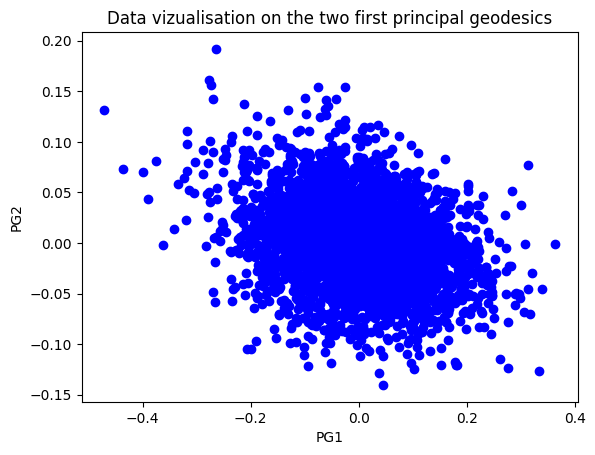

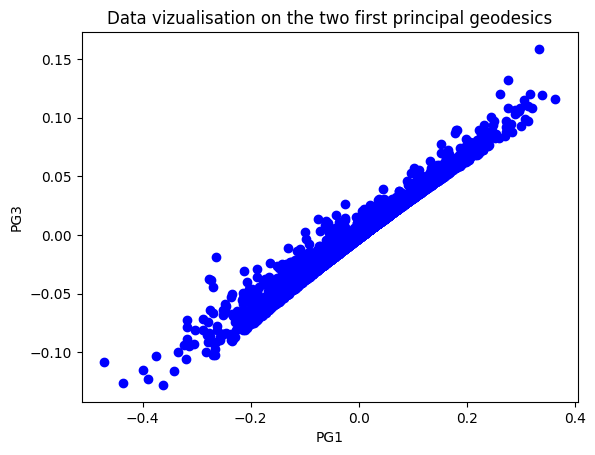

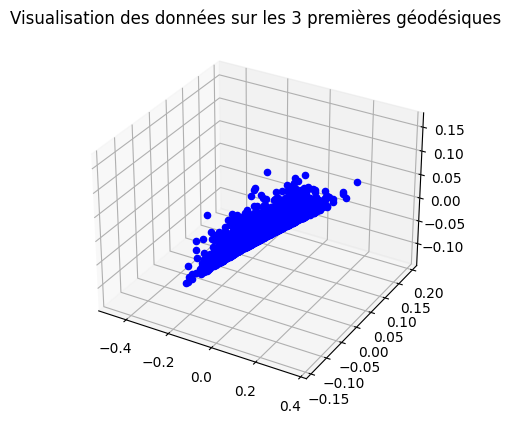

In [ ]:
visualisation_normales(projections_ben,colour = ['blue']*len(projections_ben[0]))

Maintenant, l'idée c'est d'intégrer les données anormales pour les comparer sur les mêmes graphiques. On commence par calculer les signatures des données anormales.

Ensuite, on les projette dans les 3 géodésiques principales **des données normales**.

In [ ]:
idx_mal = {}
idx_mal[0] = np.array([i for i in range(10)])
for j in range(1,36):
  idx_mal[j] = np.array([j*1000+i for i in range(10)])



In [ ]:
projections_mal = {}
for i in range(36)
  projections_mal[i] = compute_projection(t_principal_directions,data_mal[idx_mal[i]],channels = data_mal.shape[-1],depth = 3)

Computing tangent pga projections
Data #0 with component #0
Data #1 with component #0
Data #2 with component #0
Data #3 with component #0
Data #4 with component #0
Data #5 with component #0
Data #6 with component #0
Data #7 with component #0
Data #8 with component #0
Data #9 with component #0
Data #0 with component #1
Data #1 with component #1
Data #2 with component #1
Data #3 with component #1
Data #4 with component #1
Data #5 with component #1
Data #6 with component #1
Data #7 with component #1
Data #8 with component #1
Data #9 with component #1
Data #0 with component #2
Data #1 with component #2
Data #2 with component #2
Data #3 with component #2
Data #4 with component #2
Data #5 with component #2
Data #6 with component #2
Data #7 with component #2
Data #8 with component #2
Data #9 with component #2
Variance expliquée par les 3 premières géodésiques principales[0.137923133044272, 0.017925709544215067, 0.0030893535526910192]
Computing tangent pga projections
Data #0 with component #0

<ipython-input-24-ca77ee31fa67>:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  optimized_ti_t = fsolve(d2h_t, initial_guess_t)[0]


Data #0 with component #0
Data #1 with component #0
Data #2 with component #0
Data #3 with component #0
Data #4 with component #0
Data #5 with component #0


<ipython-input-24-ca77ee31fa67>:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  optimized_ti_t = fsolve(d2h_t, initial_guess_t)[0]


Data #6 with component #0
Data #7 with component #0
Data #8 with component #0
Data #9 with component #0
Data #0 with component #1
Data #1 with component #1
Data #2 with component #1
Data #3 with component #1
Data #4 with component #1
Data #5 with component #1
Data #6 with component #1
Data #7 with component #1
Data #8 with component #1
Data #9 with component #1
Data #0 with component #2
Data #1 with component #2
Data #2 with component #2
Data #3 with component #2
Data #4 with component #2
Data #5 with component #2
Data #6 with component #2
Data #7 with component #2
Data #8 with component #2
Data #9 with component #2
Variance expliquée par les 3 premières géodésiques principales[2071.6794108359827, 3712.985622754306, 281.7992036921942]
Computing tangent pga projections
Data #0 with component #0
Data #1 with component #0
Data #2 with component #0
Data #3 with component #0
Data #4 with component #0
Data #5 with component #0
Data #6 with component #0
Data #7 with component #0
Data #8 with 

In [ ]:
for i in range(36):
  print(f"data {i}")
  visualisation_all(projections_norm=projections_ben,projections_anorm=projections_mal[i])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
q0 = np.quantile(np.abs(projections_ben[0]),0.95)
q1 = np.quantile(np.abs(projections_ben[1]),0.95)
q2 = np.quantile(np.abs(projections_ben[2]),0.95)

In [ ]:
TP0 = sum(np.abs(projections_mal[0])>q0)
print(TP0/len(projections_mal[0]))
TP1 = sum(np.abs(projections_mal[1])>q1)
print(TP1/len(projections_mal[1]))
TP2 = sum(np.abs(projections_mal[2])>q2)
print(TP2/len(projections_mal[2]))

0.9416666666666667
0.9777777777777777
0.9861111111111112


Maintenant, on va regarder ce que ca donne lorsqu'on crée les géodésiques avec normales et anormales:

In [ ]:
data_all = torch.cat((data_ben,data_mal))
t_principal_directions_all, signatures_all = compute_pga(path = data_all[:40000],sig_level=3,tangent=True,n_components= 10)

Computing signatures
Computing tangent pga


In [ ]:
np.save('t_principal_directions_all_sig3_n10.npy',t_principal_directions_all)

In [ ]:
idx_mal = [i for i in range(10)]
for j in range(1,36):
  idx_mal = idx_mal + [5000+j*1000+ i for i in range(10)]
idx_mal = np.array(idx_mal)

idx_ben = [i for i in range(100)]
for j in range(1,5):
  idx_ben  += [1000*j + i for i in range(100)]

projections_ben = compute_projection(t_principal_directions_all,data_all[np.array(idx_ben)],channels = data_ben.shape[-1],depth = 3)


Computing tangent pga projections
Data #0 with component #0
Data #1 with component #0
Data #2 with component #0
Data #3 with component #0
Data #4 with component #0
Data #5 with component #0
Data #6 with component #0
Data #7 with component #0
Data #8 with component #0
Data #9 with component #0
Data #10 with component #0
Data #11 with component #0
Data #12 with component #0
Data #13 with component #0
Data #14 with component #0
Data #15 with component #0
Data #16 with component #0
Data #17 with component #0
Data #18 with component #0
Data #19 with component #0
Data #20 with component #0
Data #21 with component #0
Data #22 with component #0
Data #23 with component #0
Data #24 with component #0
Data #25 with component #0
Data #26 with component #0
Data #27 with component #0
Data #28 with component #0
Data #29 with component #0
Data #30 with component #0
Data #31 with component #0
Data #32 with component #0
Data #33 with component #0
Data #34 with component #0
Data #35 with component #0
Data

<ipython-input-13-102042795e64>:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  optimized_ti_t = fsolve(d2h_t, initial_guess_t)[0]


Data #4 with component #1
Data #5 with component #1
Data #6 with component #1
Data #7 with component #1
Data #8 with component #1
Data #9 with component #1
Data #10 with component #1
Data #11 with component #1
Data #12 with component #1
Data #13 with component #1
Data #14 with component #1
Data #15 with component #1
Data #16 with component #1
Data #17 with component #1
Data #18 with component #1
Data #19 with component #1
Data #20 with component #1
Data #21 with component #1
Data #22 with component #1
Data #23 with component #1
Data #24 with component #1
Data #25 with component #1
Data #26 with component #1
Data #27 with component #1
Data #28 with component #1
Data #29 with component #1
Data #30 with component #1
Data #31 with component #1
Data #32 with component #1
Data #33 with component #1
Data #34 with component #1
Data #35 with component #1
Data #36 with component #1
Data #37 with component #1
Data #38 with component #1
Data #39 with component #1
Data #40 with component #1
Data #4

In [ ]:
import pickle
with open('proj_sig3_n10_benscaled.pkl',"wb") as outfile:
  pickle.dump(projections_ben, outfile)

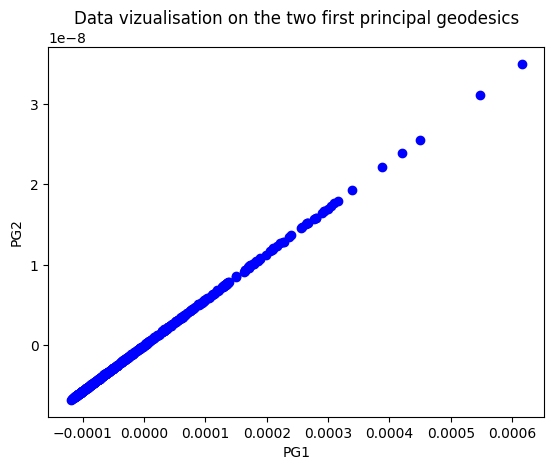

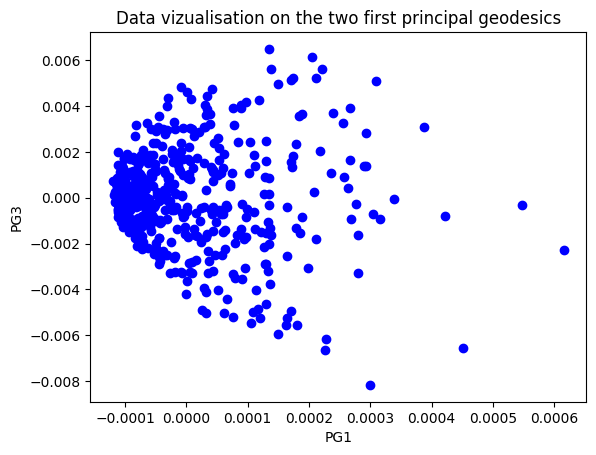

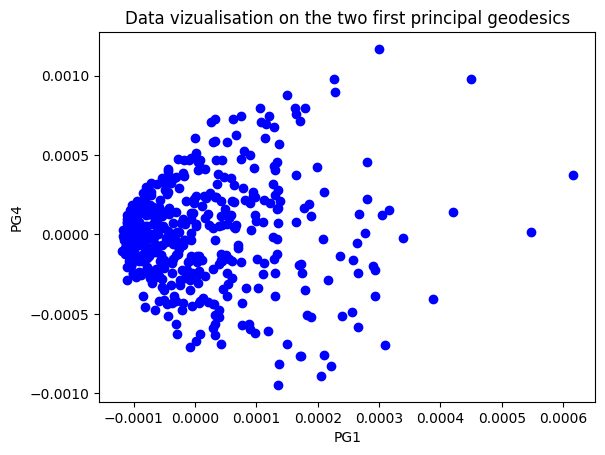

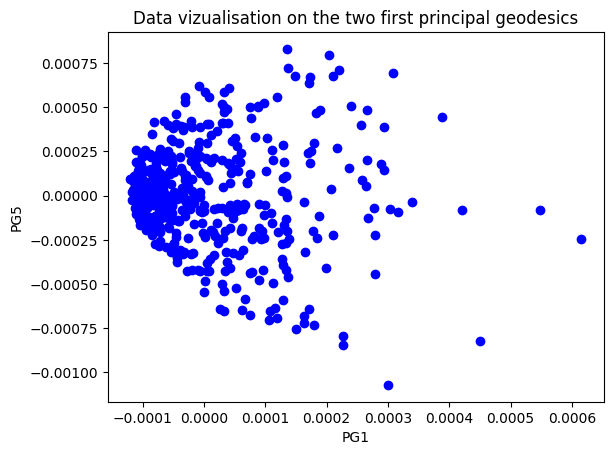

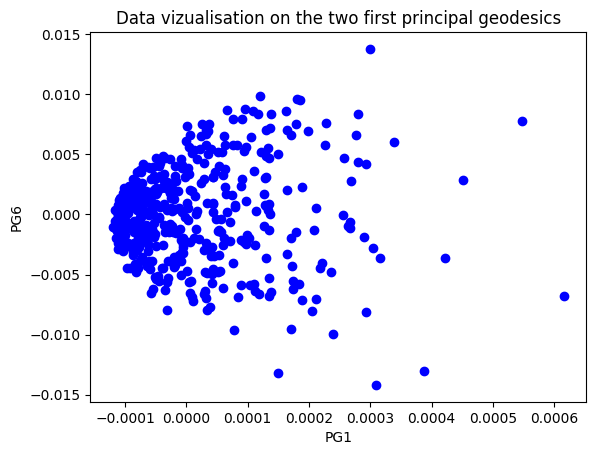

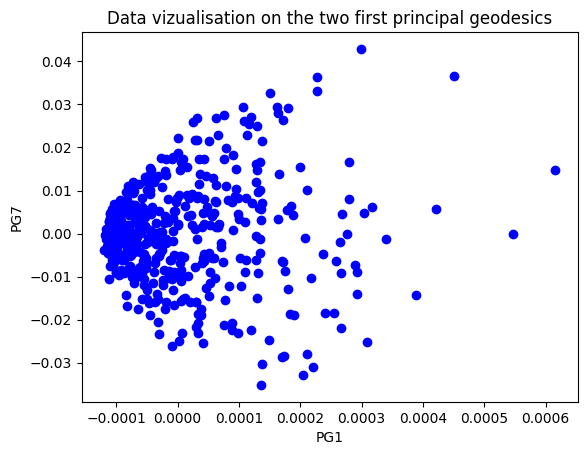

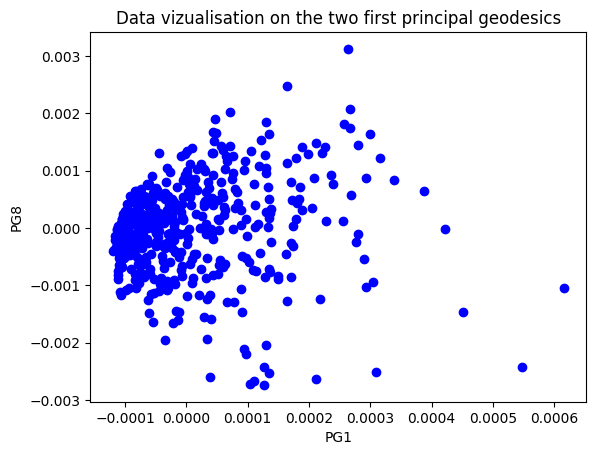

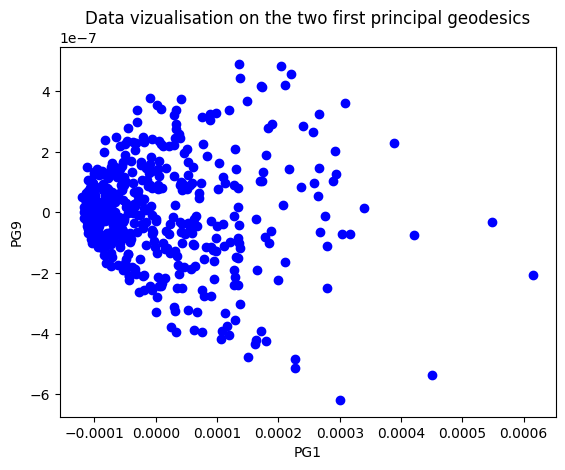

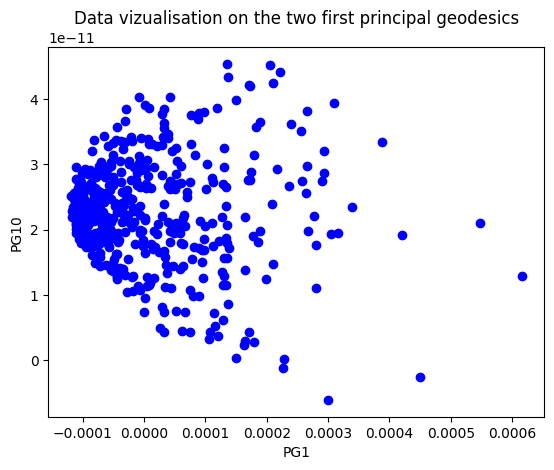

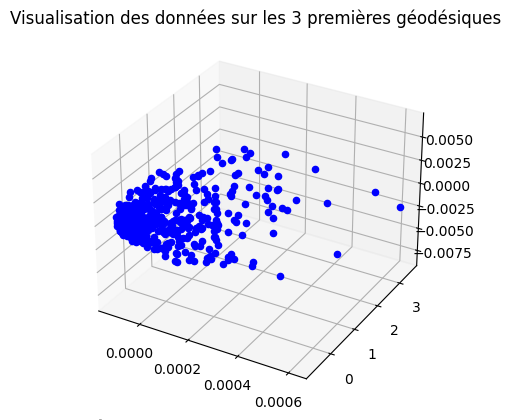

In [ ]:
visualisation_normales(projections_ben,colour = ['blue']*data_ben.shape[0])


In [ ]:
projections_mal = compute_projection(t_principal_directions_all,data_all[np.array(idx_mal)],channels = data_mal.shape[-1],depth = 3)


Computing tangent pga projections


<ipython-input-13-102042795e64>:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  optimized_ti_t = fsolve(d2h_t, initial_guess_t)[0]


Data #0 with component #0
Data #1 with component #0
Data #2 with component #0
Data #3 with component #0
Data #4 with component #0
Data #5 with component #0
Data #6 with component #0
Data #7 with component #0
Data #8 with component #0
Data #9 with component #0
Data #10 with component #0
Data #11 with component #0
Data #12 with component #0
Data #13 with component #0
Data #14 with component #0
Data #15 with component #0
Data #16 with component #0
Data #17 with component #0
Data #18 with component #0
Data #19 with component #0
Data #20 with component #0
Data #21 with component #0
Data #22 with component #0
Data #23 with component #0
Data #24 with component #0
Data #25 with component #0
Data #26 with component #0
Data #27 with component #0
Data #28 with component #0
Data #29 with component #0
Data #30 with component #0
Data #31 with component #0
Data #32 with component #0
Data #33 with component #0
Data #34 with component #0
Data #35 with component #0
Data #36 with component #0
Data #37 wi

In [ ]:
import pickle
with open('proj_sig3_n10_mal_scaled.pkl',"wb") as outfile:
  pickle.dump(projections_mal, outfile)

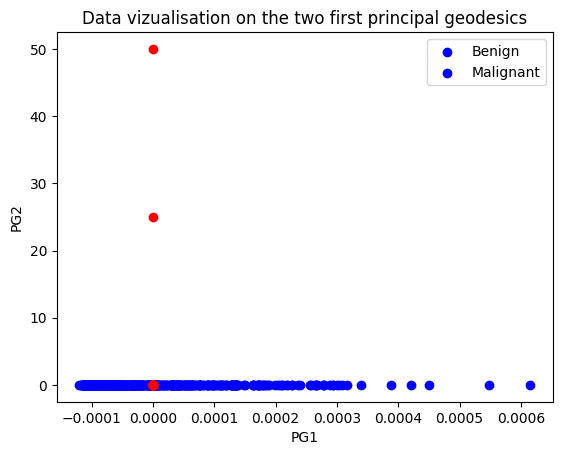

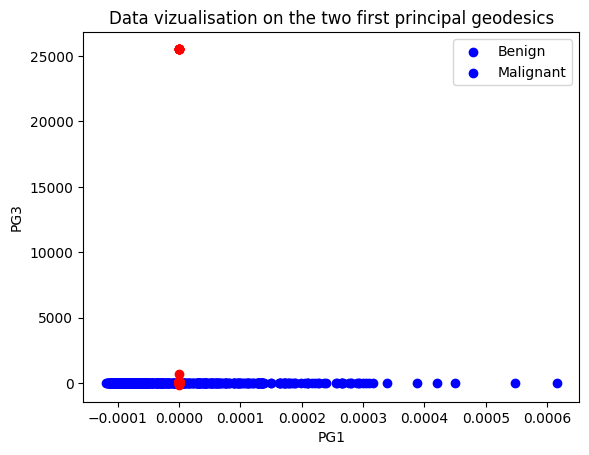

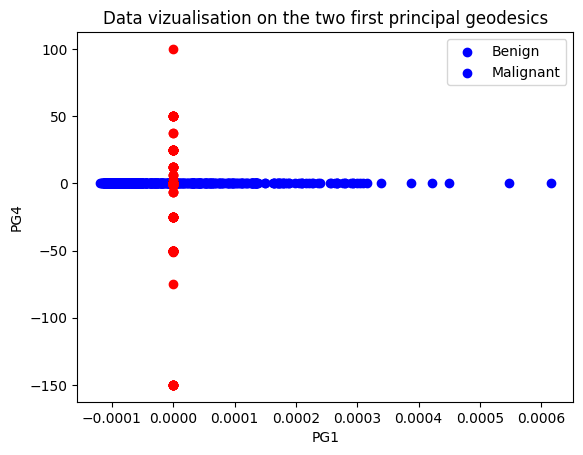

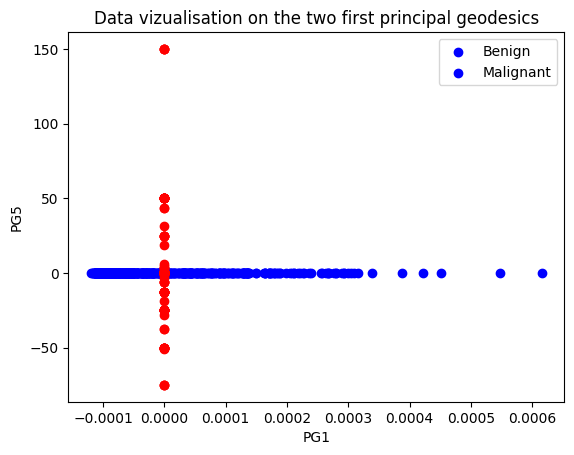

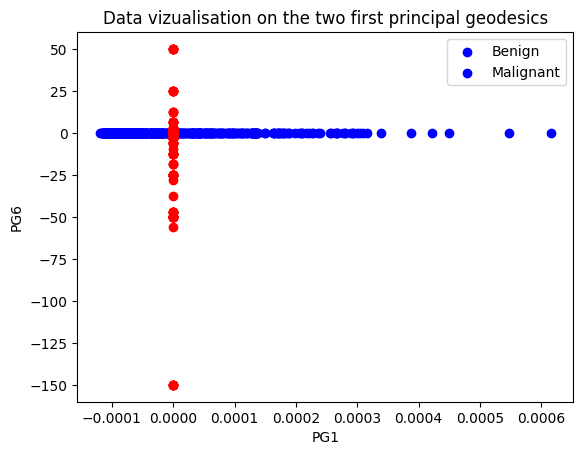

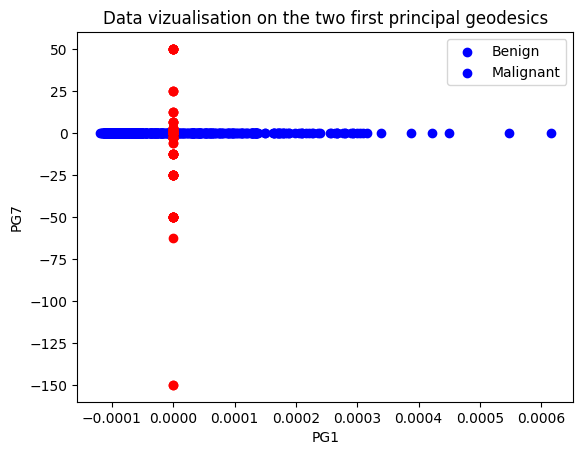

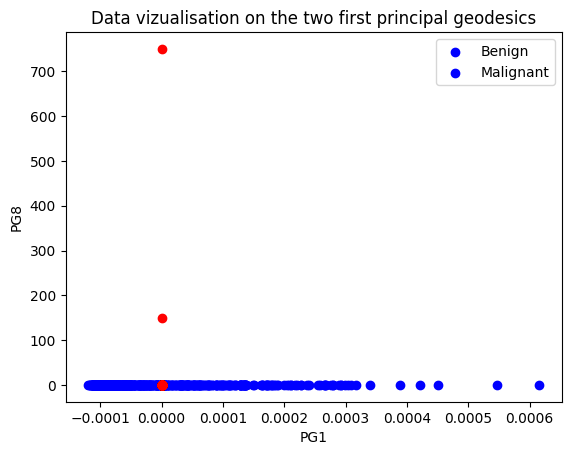

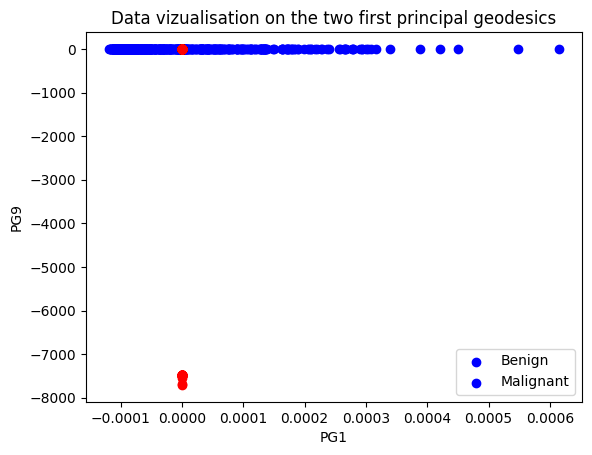

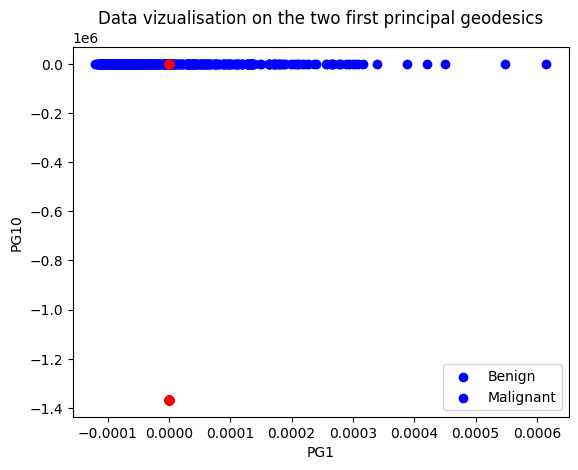

In [ ]:
visualisation_all(projections_norm=projections_ben,projections_anorm=projections_mal)